In [153]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance
import re

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN

from ingeniring_utils import * # import all existing functions from file cleaning.py
from modeling_utils import *

%load_ext autoreload
%autoreload 2


pd.set_option('display.max_columns', 360)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
# Loading Data

df = pd.read_csv('data/df.csv')

In [136]:
df.columns

Index(['ticket_id', 'agency_name', 'disposition', 'discount_amount',
       'judgment_amount', 'compliance', 'lon', 'lat', 'parcel_id', 'AddCombo',
       'Structure', 'Condition', 'Occupancy', 'Needs_Boarding', 'Fire',
       'Dumping', 'Units'],
      dtype='object')

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78823 entries, 0 to 78822
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticket_id        78823 non-null  int64  
 1   agency_name      78823 non-null  object 
 2   disposition      78823 non-null  object 
 3   discount_amount  78823 non-null  float64
 4   judgment_amount  78823 non-null  float64
 5   compliance       78823 non-null  float64
 6   lon              78823 non-null  float64
 7   lat              78823 non-null  float64
 8   parcel_id        78823 non-null  int64  
 9   AddCombo         78823 non-null  object 
 10  Structure        78823 non-null  object 
 11  Condition        78823 non-null  object 
 12  Occupancy        78823 non-null  object 
 13  Needs_Boarding   78823 non-null  object 
 14  Fire             78823 non-null  object 
 15  Dumping          78823 non-null  object 
 16  Units            78823 non-null  object 
dtypes: float64(5

In [138]:
# define target variable and categorical features

target = df['compliance']

features = ['agency_name', 'disposition', 'discount_amount',
            'judgment_amount', 'Structure', 'Condition', 'Occupancy',
            'Needs_Boarding', 'Fire', 'Dumping', 'Units']

numeric_features = ['discount_amount', 'judgment_amount']

cat_features = ['agency_name', 'disposition', 'Structure', 'Condition', 
                 'Occupancy', 'Needs_Boarding', 'Fire', 'Dumping', 'Units']

In [139]:
numeric_var_analysis(df, numeric_features)

Continuous Variables
                   count        mean         std  min    25%    50%    75%  \
discount_amount  78823.0    0.190744    3.967237  0.0    0.0    0.0    0.0   
judgment_amount  78823.0  398.172263  698.438851  0.0  167.5  305.0  305.0   

                     max  
discount_amount    350.0  
judgment_amount  11030.0  


In [140]:
categor_var_analysis(df, cat_features)

Discrete Variables
agency_name
Buildings, Safety Engineering & Env Department    46979
Department of Public Works                        26124
Detroit Police Department                          2230
Health Department                                  3490
Name: agency_name, dtype: int64
--------------------------------------------------------------------------------
disposition
Responsible (Fine Waived) by Deter       93
Responsible by Admission               7035
Responsible by Default                67913
Responsible by Determination           3782
Name: disposition, dtype: int64
--------------------------------------------------------------------------------
Structure
no         4
yes    78819
Name: Structure, dtype: int64
--------------------------------------------------------------------------------
Condition
fair                  15898
good                  54535
poor                   5773
suggest demolition     2617
Name: Condition, dtype: int64
--------------------------------

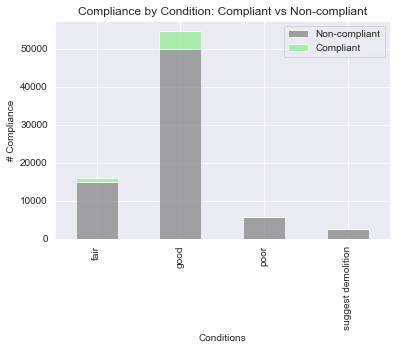

In [141]:
# Condition class visualization


condition = df.groupby(['Condition','compliance']).Condition.count().unstack()
p1 = condition.plot(kind = 'bar', stacked = True, 
                   title = 'Compliance by Condition: Compliant vs Non-compliant', 
                   color = ['grey','lightgreen'], alpha = .70)

p1.set_xlabel('Conditions')
p1.set_ylabel('# Compliance')
p1.legend(['Non-compliant','Compliant'])
plt.show()

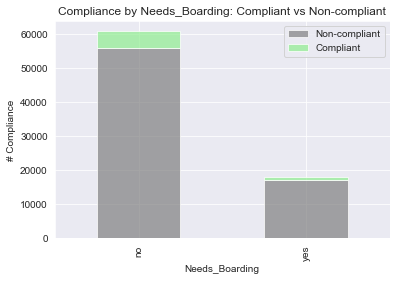

In [142]:
# Condition class visualization


Needs_Boarding = df.groupby(['Needs_Boarding','compliance']).Needs_Boarding.count().unstack()
p1 = Needs_Boarding.plot(kind = 'bar', stacked = True, 
                   title = 'Compliance by Needs_Boarding: Compliant vs Non-compliant', 
                   color = ['grey','lightgreen'], alpha = .70)

p1.set_xlabel('Needs_Boarding')
p1.set_ylabel('# Compliance')
p1.legend(['Non-compliant','Compliant'])
plt.show()

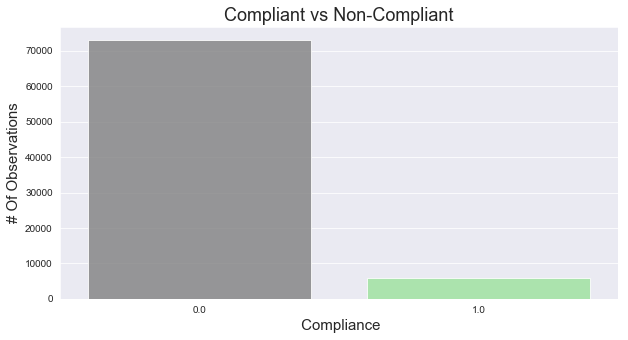

In [143]:
# Target Variable Countplot

sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(target, alpha =.80, palette= ['grey','lightgreen'])
plt.title('Compliant vs Non-Compliant', size = 18)
plt.ylabel('# Of Observations', size =15)
plt.xlabel(' Compliance', size =15)
plt.show()

In [147]:
#  Creating dummy variables for categorical variables wit function to_dummies.
X = to_dummies(df[features], cat_features)
y = target

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)

In [149]:
# Training set
print('Train set : \n ')
print(y_train.value_counts())
print('\n Test set :\n  ')
# Test set
print(y_test.value_counts())

Train set : 
 
0.0    54777
1.0     4340
Name: compliance, dtype: int64

 Test set :
  
0.0    18283
1.0     1423
Name: compliance, dtype: int64


AUC: 0.8028561952243845


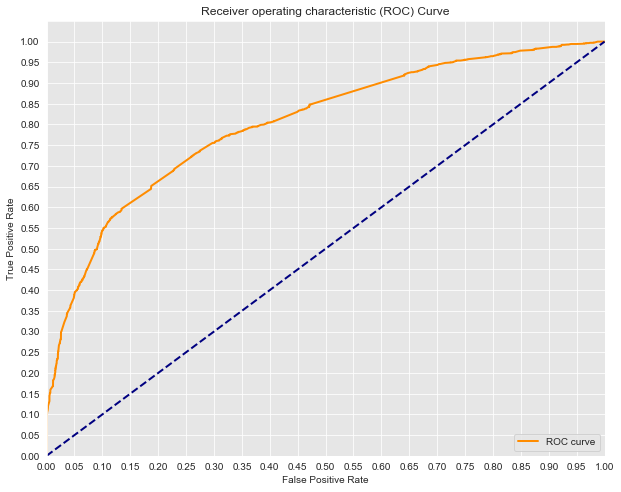

In [150]:
# Initial Model
logreg = LogisticRegression(fit_intercept=False, solver='liblinear')
logreg.fit(X_train, y_train)

# Probability scores for test set
y_score = logreg.fit(X_train, y_train).decision_function(X_test)
# False positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Print AUC
print('AUC: {}'.format(auc(fpr, tpr)))

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

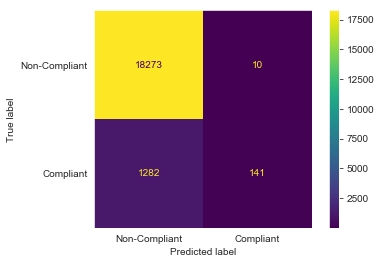

In [157]:
# Plot confusion matrix of the test set
plot_confusion_matrix(logreg, X_test, y_test,
                      display_labels=["Non-Compliant", "Compliant"],
                      values_format=".5g")
plt.grid(False) # removes the annoying grid lines from plot
plt.show()

### Use the SMOTE class from the imblearn package in order to improve the model's performance on the minority class.